In [1]:
from udma import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cb=UDMA_CLASS("140.105.17.180", 7)
# cb=UDMA_CLASS("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

Comblock Registers

|Register | Connection |
| ----- | ---- |
|reg0_o | Config_Res_intan_A|
|reg1_o | Config_Res_intan_B|
|reg2_o | Config_Res_intan_C|
|reg3_o | Config_Res_intan_D|
|reg4_o | Read_intan(3:0)|
|reg5_o | Sys_reset (active low)|
|reg6_o | **Combintan_w_header**/nsamples |
|reg7_o | **Combintan_w_header**/sys_en |



In [6]:
def hicce_init():
    # Select comblock
    cb.select_comblock(0)
    # Reset HiCCE
    cb.write_reg(5, 0) #RESET ON
    cb.write_reg(5, 1) #RESET OFF

    #Disable Acquisiton 
    cb.write_reg(4, 0)
    cb.write_reg(7, 0)

    # FIFO Clear
    cb.select_comblock(0)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(1)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(0)

    # Configure INTANT (Reset Counter)
    cb.write_reg(0, 6150)
    cb.write_reg(1, 6150)
    cb.write_reg(2, 6150)
    cb.write_reg(3, 6150)
    # Configure INTANT (Cyclic Read)
    cb.write_reg(0, 6182)
    cb.write_reg(1, 6182)
    cb.write_reg(2, 6182)
    cb.write_reg(3, 6182)

def enable_acquisition(N=3200):
    #Set number of samples per package
    cb.write_reg(6, N)

    #Enable acquisition
    cb.write_reg(4, 15)
    cb.write_reg(7,1)

def read_channels(NCh=1, NSamp=3200):
    dataAB=[]
    dataCD=[]
    for i in range(NCh):
        cb.select_comblock(0)
        dataAB+=cb.read_fifo(NSamp+4)[1]
        cb.select_comblock(1)
        dataCD+=cb.read_fifo(NSamp+4)[1]
        return dataAB, dataCD

def decode(dpack):
    head=dpack[0]
    if head>>24 == 0x01:
        CEN=(head>>16) & 0xff
        SBT=(head>>8) & 0xff
        SAT=head & 0xff
        TS=dpack[1]<<32 | dpack[2]
        CH=[]
        for i in range(64):
            CH.append([])
        
        for i in range(len(dpack[3:])):
            d=dpack[i+3]
            if d>>24 ==0x04:
                CENT=(d>>24) & 0xff
                FLAGS=d & 0xffff
                break
            else:
                CH[(i%32)].append((d>>16)/2**16)
                CH[(i%32)+32].append((d&0xffff)/2**16)
        
    return CEN, SBT, SAT, TS, CH, CENT, FLAGS

In [7]:
hicce_init()
enable_acquisition(3200)


In [11]:
ab,cd=read_channels(1, 3200)
DAB=decode(ab)
DCD=decode(cd)
#Timestamp and Channels 0-64 from AB
TSAB=DAB[3]
CHAB=DAB[4]
#Timestamp and Channels 0-64 from CD
TSCD=DCD[3]
CHCD=DCD[4]

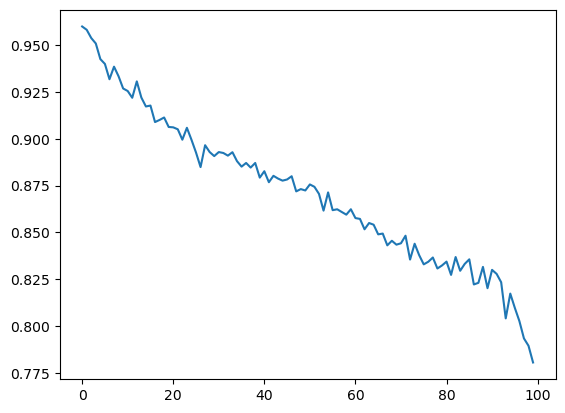

In [12]:
plt.plot(CHCD[63])

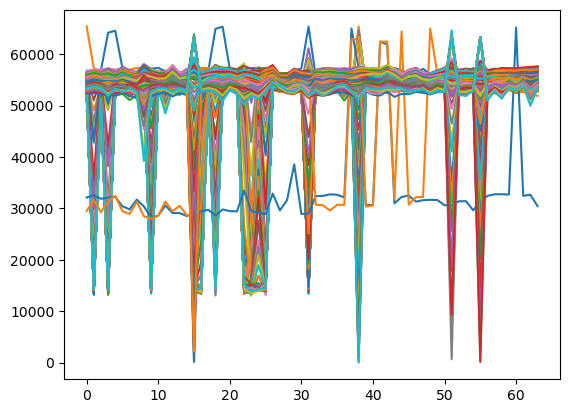

In [ ]:
plt.plot(CHAB)
plt.plot(CHCD)